# Twitter - Sentiment Analysis

In [48]:
import tweepy as tp
import pandas as pd
import numpy as np
import os
import time
import string

from textblob import TextBlob
from datetime import datetime
from dotenv import load_dotenv

In [2]:
# constants
PATH = os.path.expanduser('~') + '/'
env_file = '.env'
today = datetime.today().strftime('%Y-%m-%d')

## Connect to Twitter API

In [3]:
def env_reader(env_path):
    '''
    This function will read the environment variables given the location of where the
    .env file is located
    '''
    if not load_dotenv(env_path):
        return print('Environment File Not Found')
    return print('Loaded!')

env_reader(os.getcwd() + '/' + env_file)

Loaded!


In [4]:
def connect_twitter(api_key, secret_key, access_token, secret_access_token):
    '''
    This function will create a connection to the twitter api using the necessary
    credentials associated to the project.
    
    params:
        api_key (String) : Taken from twitter developer account
        secret_key (String) : Taken from twitter developer account
        access_token (String) : Taken from twitter developer account
        secret_access_token (String) : Taken from twitter developer account
         
    returns:
        This function will return an API which can be called
    '''
    auth = tp.OAuthHandler(
        consumer_key = api_key, 
        consumer_secret = secret_key
    )
    auth.set_access_token(
        key =  access_token, 
        secret = secret_access_token
    )
    api = tp.API(auth)
    
    try:
        api.verify_credentials()
        print("Connection to Twitter established.")
    except:
        print("Failed to connect to Twitter.")
    return api

api = connect_twitter(
    api_key = os.getenv("twitter_api_key"), 
    secret_key = os.getenv("twitter_secret"),
    access_token = os.getenv("twitter_access_token"),
    secret_access_token = os.getenv("twitter_access_token_secret")
)

Connection to Twitter established.


## Get Tweets

In [5]:
def mk_dir(path, date):
    '''
    The purpose of this function is to make a directory if one does not exist of the current
    date in the data folder.
    
    params:
        path (String) : The path to the data folder
        date (String) : The current date yyyy-mm-dd
        
    returns:
        This function will do nothing if the folder already exists, otherwise it will create
        the folder
    
    example:
        mk_dir(path = './data/', date = '2021-09-23')
    '''
    
    # check if directory exists 
    exists = os.path.exists(path + date)
    
    if not exists:
        os.makedirs(path + date)
        print("New Directory Created")

In [6]:
def get_all_tweets(screen_name, api = api, today = today):
    '''
    This function will get the latest ~3200 tweets associated to a twitter screen name.
    It will proceed to get the tweet id, created at and the content and store it in a df.
    It will save the associated results in a CSV file.
    
    params:
        screen_name (String) : The twitter handle associated to the user you want to get
                               tweets from
        api (API) : The tweepy API connection
        today (String) : Todays date in string format
    
    returns:
        This function will return a df associated to the tweet id, created_at and content
        
    source:
        [yanofsky](https://gist.github.com/yanofsky/5436496)
    '''
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
#         print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
#         print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [
        [
            t.author.name, t.id_str, t.created_at, t.text, t.entities.get('hashtags'), t.author.location,
            t.author.created_at, t.author.url, t.author.screen_name, t.favorite_count, t.favorited,
            t.retweet_count, t.retweeted, t.author.followers_count, t.author.friends_count
        ] for t in alltweets
    ]
    
    #write the csv  
    cols = [
        'author_name', 'tweet_id', 'tweet_created_at', 'content', 'hashtags', 'location',
        'author_created_at', 'author_url', 'author_screen_name', 'tweet_favourite_count', 'tweet_favourited', 
        'retweet_count', 'retweeted', 'author_followers_count', 'author_friends_count'
    ]
    df = pd.DataFrame(outtweets, columns = cols)
    mk_dir(path = './data/', date = today)
    df.to_csv('./data/{}/{}_tweets_{}.csv'.format(today, screen_name, today), index = False)
    time.sleep(10)
    return df

In [7]:
def read_tweet_data(path):
    '''
    This function will identify if todays data has already been scraped from the twitter API.
        - If it has been scraped, this function will read all the scraped data from today 
           and previous days
    Upon fetching all the data, it will drop duplicates on the tweet_id and tweet_created_at
    columns to remove duplicated tweets scraped from previous days.
    
    params:
        path (String) : The path to the data folder
        today (String) : Today's date in string format yyyy-mm-dd
        
    returns:
        This function will return the tweets_df associated to tweets from all handles over 
        the past few months
        
    example:
        read_tweet_data(
            path = './data/'
        )
    '''
    
    # get all non hidden subdirectories from the path
    sub_dir = [d for d in os.listdir(path) if d[0] != '.']
    
    # read csv from all sub directories and concat results
    files = []
    for d in sub_dir:
        for p in os.listdir(path + d):
            if p[0] != '.':
                files.append(path + d + '/' + p)

    read_csvs = []
    for file in files:
        read_csvs.append(pd.read_csv(file, converters={'hashtags': eval}, encoding='utf-8-sig'))

    read_csvs = pd.concat(read_csvs)
    tweets_df = read_csvs.drop_duplicates(subset = ['tweet_id', 'tweet_created_at'])
    return tweets_df

In [8]:
handles = [
    'TPSOperations', 'TorontoPolice', 'HamiltonPolice', 'YRP', 'SouthSimcoePS', 'BarriePolice', 'HaltonPolice',
    'DRPS', 'PeelPolice', 'HRPSOak'
]

In [9]:
%%time
if today not in os.listdir():
    for user in handles:
        print(user)
        _ = get_all_tweets(user)

TPSOperations
New Directory Created
TorontoPolice
HamiltonPolice
YRP
SouthSimcoePS
BarriePolice
HaltonPolice
DRPS
PeelPolice
HRPSOak
CPU times: user 13.9 s, sys: 1.88 s, total: 15.8 s
Wall time: 3min 9s


In [10]:
%%time
tweets_df = read_tweet_data(
    path = './data/'
)

CPU times: user 502 ms, sys: 43.9 ms, total: 546 ms
Wall time: 661 ms


In [12]:
tweets_df.shape

(35726, 15)

In [14]:
tweets_df.columns

Index(['author_name', 'tweet_id', 'tweet_created_at', 'content', 'hashtags',
       'location', 'author_created_at', 'author_url', 'author_screen_name',
       'tweet_favourite_count', 'tweet_favourited', 'retweet_count',
       'retweeted', 'author_followers_count', 'author_friends_count'],
      dtype='object')

## Preprocess Data

In [15]:
def parse_hashtags(row):
    if row['hashtags_count'] > 1:
        tags = row['hashtags']
        hashies = []
        for t in tags:
            hashies.append(t['text'])
        return hashies
    return None

In [16]:
tweets_df['hashtags_count'] = tweets_df['hashtags'].apply(lambda x : len(x))

In [17]:
%time tweets_df['hashtags'] = tweets_df.apply(lambda x : parse_hashtags(x), axis = 1)

CPU times: user 194 ms, sys: 25.6 ms, total: 220 ms
Wall time: 231 ms


In [21]:
tweets_df['tweet_created_at'] = pd.to_datetime(tweets_df['tweet_created_at'], format='%Y-%m-%d %H:%M:%S', utc=True)
tweets_df['tweet_created_at'] = tweets_df['tweet_created_at'].dt.strftime('%Y-%m-%d')

In [22]:
authors = tweets_df['author_name'].unique()

In [53]:
def remove_punctuation(tweet):
    '''
    This function will remove all punctuations from the tweet passed in
    '''
    return ''.join(ch for ch in s if ch not in set(string.punctuation))

def remove_sw(tweet):
    '''
    This function will remove all stopwords from the tweet passed in
    '''
    sw = [
        'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out',
 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of',
 'most', 'itself', 'other', 'off', 'is', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until',
 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this',
 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at',
 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because',
 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too',
 'only', 'myself', 'which', 'those', 'i', 'after', 'few',
 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'
    ]
    tweet=tweet.lower()
    tweet = ' '.join(w for w in tweet.split(' ') if w not in sw)
    return tweet

In [54]:
tweets_df['cleaned_tweet'] = tweets_df['content'].apply(remove_punctuation)
tweets_df['cleaned_tweet'] = tweets_df['content'].apply(remove_sw)

## Calculate Sentiment of Tweet

In [60]:
def tweet_sentiment(tweet):
    '''
    Identify the sentiment associated to a tweet.
    
    params:
        tweet (String) : The stirng you want the sentiment of
        
    returns:
        A score between -1 and 1, where values greater than 0
        would indicate a positive sentiment and values less
        than 0 would be negative. Values = 0 is a neutral
        sentiment tweet.
    '''
    tb = TextBlob(tweet)
    score = tb.sentiment.polarity
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [61]:
tweets_df['tweet_sentiment'] = tweets_df['cleaned_tweet'].apply(tweet_sentiment)

Text(0.5, 0, 'Frequency of Tweet Sentiment')

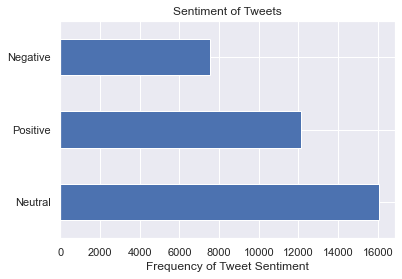

In [65]:
plt.clf()
tweets_df['tweet_sentiment'].value_counts().plot(kind = 'barh')
plt.title('Sentiment of Tweets')
plt.xlabel('Frequency of Tweet Sentiment')

In [72]:
tweets_df[tweets_df['tweet_sentiment'] == 'Positive'].content.sample(5).values

array(["Smartest idea we've heard all night! Way to be a responsible driver! ^MRT https://t.co/htkoL5EpKJ",
       'Hanukkah Sameach! May this festival of light and joy bring blessings of health, happiness and prosperity. https://t.co/0bq0dKNFc3',
       'RT @CACP_ACCP: On this National Day of Remembrance &amp; Action on Violence Against Women, we are proud to launch the Canadian Framework for Co…',
       'RT @Oakvillehydro: The potential for heavy rainfall and strong winds are expected throughout the day. If you see a downed power line, stay…',
       'Joining forces with our @simcoecounty Paramedics! Collecting new and unwrapped toys at #Barrie north-end #Walmart !… https://t.co/BvZ0efzTod'],
      dtype=object)

In [73]:
tweets_df[tweets_df['tweet_sentiment'] == 'Negative'].content.sample(5).values

array(['COLLISION:\nFGX/Parklawn, single vehicle involved, E/B express lanes approaching Lakeshore exit, 2 lanes closed.… https://t.co/Pz5hBIC0H9',
       '@Toronto_Fire @TorontoMedics FIRE: (UPDATE)\nDunn Ave &amp; Queen St W\n- roads have re-opened\n#GO1455141\n^al',
       "Bollywood superstar's son walks out from jail in drugs case\nhttps://t.co/Yf9ytlkNiF https://t.co/vsdkYzQnad",
       '@davidrazi Hi David - Fines are a last resort and are only issued if individuals are entering a closed area. For ex… https://t.co/Tf6LuIfCjm',
       'Police seek help locating a stolen dog, Kipling Avenue and Henley Crescent area, Black and tan Pug, named Bugsy https://t.co/3mBovOgNA5'],
      dtype=object)

In [74]:
tweets_df[tweets_df['tweet_sentiment'] == 'Neutral'].content.sample(5).values

array(['Remember to follow our @DRPSCommunity account for helpful safety tips during Crime Prevention Week. #CPWeek2020 https://t.co/vGO8saST4r',
       'The #BarriePolice is reminding the public that you DO NOT have to pay money to receive a lottery prize. If you get… https://t.co/G5H2dsc468',
       'Road closure on Dundas St East in Whitby between Hopkins and Craydon for Police Investigation.',
       'It’s “my face hurts” weather out there. \n\nIf you’re heading out for a walk, or to shovel, you might want to bundle… https://t.co/GlLzZ5xLOg',
       'Officers from @DRPSNorthDiv rescued a stranded seadoo on Lake Scugog with the help of Air1, 9-1-1 Communications an… https://t.co/WUbGJ5jJfo'],
      dtype=object)